In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import r2_score

import itertools

from pmdarima import auto_arima

from pandas.tseries.offsets import DateOffset
  

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Walmart.csv', parse_dates=['Date'])
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [3]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,5,17
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,12,48
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,5,18


In [4]:
#creating a function that takes store as an input & returns  a storewise dataframe sorted as per year & weeks

def storewiseData(dataframe, store):
    df1 = dataframe[dataframe['Store'] == store]
    df1.sort_values(['Year', 'Week'], inplace = True)
    return df1

In [5]:
store = 2

In [6]:
df_storewise = storewiseData(df, store)
df_storewise

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
177,2,2010-01-10,1827440.43,0,69.24,2.603,211.329874,8.163,2010,1,1
151,2,2010-02-04,2066187.72,0,63.27,2.719,210.479887,8.200,2010,2,5
164,2,2010-02-07,2003940.64,0,82.74,2.669,210.880373,8.099,2010,2,5
145,2,2010-02-19,2124451.54,0,39.69,2.514,210.945160,8.324,2010,2,7
146,2,2010-02-26,1865097.27,0,46.10,2.561,210.975957,8.324,2010,2,8
...,...,...,...,...,...,...,...,...,...,...,...
274,2,2012-10-08,1866719.96,0,88.55,3.494,221.595414,6.565,2012,10,41
284,2,2012-10-19,1847990.41,0,68.08,3.594,223.059808,6.170,2012,10,42
285,2,2012-10-26,1834458.35,0,69.79,3.506,223.078337,6.170,2012,10,43
261,2,2012-11-05,1917520.99,0,73.87,3.688,221.363221,6.891,2012,11,45


In [7]:
#creating a function that will calculate values of sales per week for each year 2010 to 2012 & returns a dataframe with weekly sales

def sales_per_week(dataframe):
    year = dataframe['Year'].unique()
    week = []
    sales_per_week = []
    
    
    for i in range(len(year)):
        df_year = dataframe[dataframe['Year'] == year[i]]
        sales = df_year.groupby('Week')['Weekly_Sales'].sum()
        
        for j in range(len(sales)):
            week.append(sales.index[j])
            sales_per_week.append(sales.values[j])
          
 
            
    
    output = pd.DataFrame({'Week':week, 'Sales_per_week':sales_per_week})
    return output

In [8]:
df_sales = sales_per_week(df_storewise)
df_sales

,Week,Sales_per_week
0,1,1827440.43
1,5,4070128.36
2,7,2124451.54
3,8,1865097.27
4,10,3920389.36
...,...,...
122,41,1866719.96
123,42,1847990.41
124,43,1834458.35
125,45,1917520.99


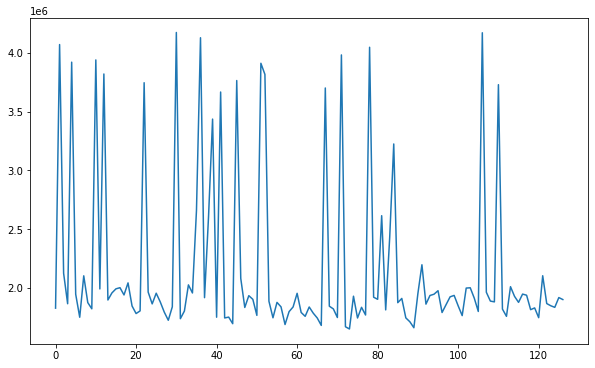

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df_sales['Sales_per_week'])
plt.show()

Since we dont have data for regular week intervals we will aggerate sales on a monthly basis

In [7]:
#creating a function that will calculate values of sales per week for each year 2010 to 2012 & returns a dataframe with weekly sales

def sales_per_month(dataframe):
    year = dataframe['Year'].unique()
    month = []
    sales_per_month = []
    
    
    for i in range(len(year)):
        df_year = dataframe[dataframe['Year'] == year[i]]
        sales = df_year.groupby('Month')['Weekly_Sales'].sum()
        
        for j in range(len(sales)):
            month.append(sales.index[j])
            sales_per_month.append(sales.values[j])
          
 
            
    
    output = pd.DataFrame({'Month':month, 'Sales_per_month':sales_per_month})
    return output

In [8]:
df_sales = sales_per_month(df_storewise)
df_sales

,Month,Sales_per_month
0,1,1827440.43
1,2,8059677.17
2,3,7616658.05
3,4,7601939.09
4,5,11801867.35
5,6,5933474.03
6,7,7474425.37
7,8,7573698.21
8,9,7354052.65
9,10,9552913.62


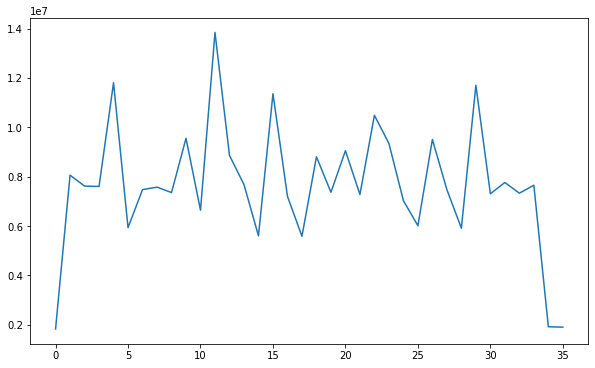

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df_sales['Sales_per_month'])
plt.show()

# Checking stationarity

In [13]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [36]:
adfuller_test(df_sales['Sales_per_month'])

ADF Test Statistic : -5.713160905059002
p-value : 7.22123381208418e-07
#Lags Used : 0
Number of Observations Used : 35
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# Determining the p, d, q values

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


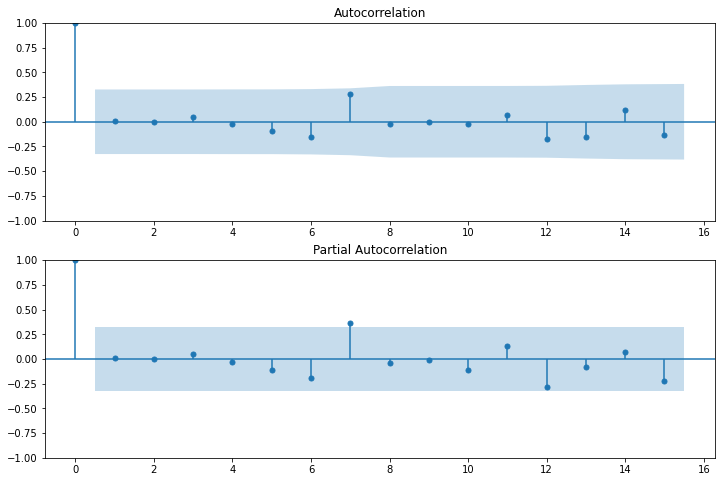

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_sales['Sales_per_month'].dropna(),lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_sales['Sales_per_month'].dropna(),lags=15,ax=ax2)

In [60]:
p = range(0,8)
q = range(0, 8)
d = range(0, 4)

In [61]:
pdq_comb = list(itertools.product(p,d,q))

In [62]:
pdq_comb

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 3, 7),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 6),
 (2, 0, 7),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2,

In [64]:
len(pdq_comb)

256

In [65]:
order_final = []
r2_list = []

In [67]:
#we will use ARIMA as data is stationary
#we will predict the values for last 12 months
#Then we wil calculate R2_score for all pdq combinations
#we will find that pdq for which R2_score is max

for pdq in pdq_comb:
    try:
        model = ARIMA(df_sales['Sales_per_month'], order = pdq).fit()    
        pred = model.predict(start = 24)                                  
        r2 = r2_score(df_sales['Sales_per_month'][24:], pred)
        order_final.append(pdq)
        r2_list.append(r2)
    except:
        continue
        
        

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604:

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\state

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: Converge

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\states

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: Converge

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\t

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\states

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\states

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\t

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
df_results = pd.DataFrame({'Order':order_final, 'R2_score':r2_list})
df_results

,Order,R2_score
0,"(0, 0, 0)",-1.060949e-01
1,"(0, 0, 1)",-9.873517e-02
2,"(0, 0, 2)",-9.898902e-02
3,"(0, 0, 3)",6.478960e-02
4,"(0, 0, 4)",6.847652e-02
...,...,...
250,"(7, 3, 3)",4.175850e-01
251,"(7, 3, 4)",5.679732e-01
252,"(7, 3, 5)",5.062664e-01
253,"(7, 3, 6)",2.714653e-01


In [71]:
df_results_final = df_results[df_results['R2_score'] == df_results['R2_score'].max()]

In [72]:
df_results_final

,Order,R2_score
238,"(7, 1, 6)",0.698139


We will take p = 7, d = 1, q = 6

# Fitting ARIMA model

In [9]:
model = ARIMA(df_sales['Sales_per_month'],order=(7,1,6))
model_fit = model.fit()

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Sales_per_month   No. Observations:                   36
Model:                 ARIMA(7, 1, 6)   Log Likelihood                -566.609
Date:                Tue, 10 Jan 2023   AIC                           1161.217
Time:                        10:58:02   BIC                           1182.992
Sample:                             0   HQIC                          1168.734
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0403      0.329     -3.158      0.002      -1.686      -0.395
ar.L2         -0.3989      0.256     -1.561      0.119      -0.900       0.102
ar.L3         -0.3559      0.144     -2.477      0.013      -0.638      -0.074
ar.L4         -0.3499      0.137     -2.545      0.011      -0.619      -0.080
ar.L5         -0.7875      0.147     -5.362      0.000      -1.075      -0.500
ar.L6         -1.1787      0.241     -4.892      0.000      -1.651      -0.706
ar.L7         -0.3065      0.256     -1.197      0.231      -0.808       0.195
ma.L1          0.5873      4.187      0.140      0.888      -7.619       8.794
ma.L2         -0.0871      1.031     -0.085      0.933      -2.107       1.933
ma.L3          0.3879      0.806      0.481      0.630      -1.192       1.967
ma.L4          0.2951      0.995      0.297      0.767      -1.655       2.245
ma.L5          0.5326      3.203      0.166      0.868      -5.746       6.811
ma.L6          0.7928      0.258      3.074      0.002       0.287       1.298
sigma2      2.069e+12   4.19e-12   4.94e+23      0.000    2.07e+12    2.07e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.51   Prob(JB):                         0.27
Heteroskedasticity (H):               0.32   Skew:                             0.62
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.13e+40. Standard errors may be unstable.
"""

<AxesSubplot:>

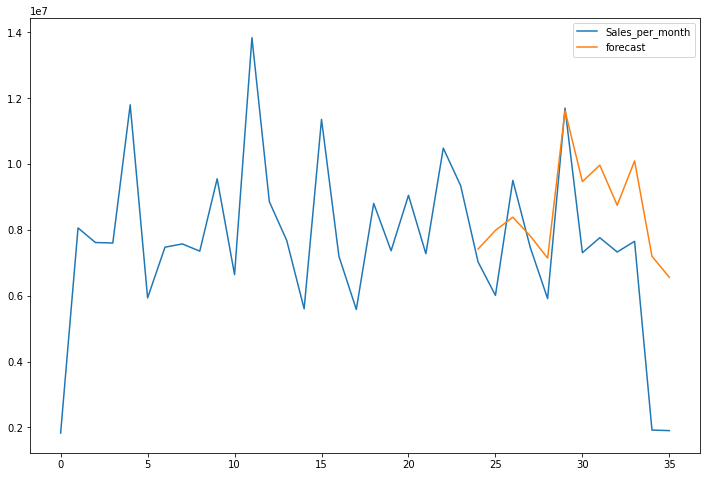

In [11]:
df_sales['forecast']=model_fit.predict(start=24, dynamic=True)
df_sales[['Sales_per_month','forecast']].plot(figsize=(12,8))

The max R2_score using ARIMA is 0.69

# Predicting the future sales for next 12 months

In [24]:
df_sales

,Month,Sales_per_month,forecast
0,1,1827440.43,NaN
1,2,8059677.17,NaN
2,3,7616658.05,NaN
3,4,7601939.09,NaN
4,5,11801867.35,NaN
5,6,5933474.03,NaN
6,7,7474425.37,NaN
7,8,7573698.21,NaN
8,9,7354052.65,NaN
9,10,9552913.62,NaN


In [27]:
futuremonth = [int(x) for x in range(1, 13)]
future_df = pd.DataFrame({'Month':futuremonth})


In [31]:
df_future = pd.concat([df_sales, future_df], axis = 0)
df_future.reset_index(inplace = True, drop = True)
df_future

,Month,Sales_per_month,forecast
0,1,1827440.43,NaN
1,2,8059677.17,NaN
2,3,7616658.05,NaN
3,4,7601939.09,NaN
4,5,11801867.35,NaN
5,6,5933474.03,NaN
6,7,7474425.37,NaN
7,8,7573698.21,NaN
8,9,7354052.65,NaN
9,10,9552913.62,NaN


<AxesSubplot:>

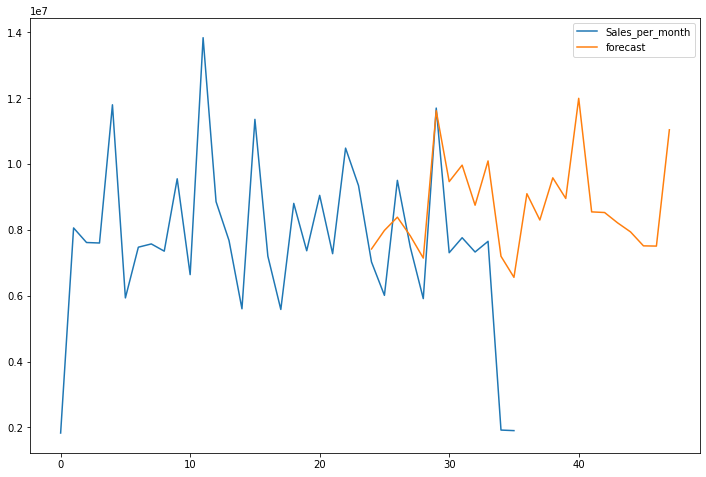

In [34]:
df_future['forecast']=model_fit.predict(start=24, end = 48, dynamic=True)
df_future[['Sales_per_month','forecast']].plot(figsize=(12,8))

In [35]:
df_future

,Month,Sales_per_month,forecast
0,1,1827440.43,NaN
1,2,8059677.17,NaN
2,3,7616658.05,NaN
3,4,7601939.09,NaN
4,5,11801867.35,NaN
5,6,5933474.03,NaN
6,7,7474425.37,NaN
7,8,7573698.21,NaN
8,9,7354052.65,NaN
9,10,9552913.62,NaN


# Using Auto ARIMA

This is not a good practice since we don't evaluate scores based on AIC & BIC. We use either RMSE or R2

In [15]:
stepwise_fit = auto_arima(df_sales['Sales_per_month'], start_p = 1, start_q = 1,
                          max_p = 8, max_q = 8,
                           seasonal = False, stationary = True,
                          trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1171.335, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1167.296, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1169.671, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1169.499, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1249.071, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.158 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:                        SARIMAX   Log Likelihood                -581.648
Date:                Mon, 09 Jan 2023   AIC                           1167.296
Time:                        04:30:14   BIC                           1170.463
Sample:                             0   HQIC                          1168.401
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    7.65e+06   4.23e+05     18.073      0.000    6.82e+06    8.48e+06
sigma2      6.327e+12   1.24e+12      5.116      0.000     3.9e+12    8.75e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.95   Prob(JB):                         0.42
Heteroskedasticity (H):               0.95   Skew:                            -0.24
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""